# Description
​
## Introduction
The project idea is to identify recombination events among herpes viruses.  Recombination is a primary source of genetic variation among certain types of viruses, such as Herpesviridae.  Recombination occurs when two species of viruses infect the same cell.  With two viral genomes in the same cell, there is an opportunity for the genomes to exchange and join regions of their genetic material.  The exact details of how recombination events occur are complex, and the identification of recombination events is not straightforward.  The phenomenon is known since 1955 and is believed to be historically important for the evolution of herpesviruses, both within strains and between species. 

## Assumptions and intuition
I assume that the nucleotide composition in regions where a foreign stretch of DNA has been inserted is divergent from the rest of the genome.  This makes intuitive sense since it is established that viruses have specific k-mer compositions.  Therefore, it should be possible to identify recombination events by constructing a statistical model of the genome and scanning for parts of the genome where there is a large degree of dissimilarity to the model.  However, such regions can also have other explanations, e.g. if the regions are conserved within entire families.


## Results
My first idea was to train an HMM on the full genome sequence and then compute the log-likelihood of subsequences of the genome under the HMM.  However, this turns out to give the same result as computing the GC-content of the regions.  As such, the HMM is not able to identify any specific regions within the genome to a greater extent than just the GC content would.  

I then tried to compute the 4-mer (among others) frequencies (normalised by the nucleotide frequencies) and compared these to the subsequences of the genomes.  The intuition is that we would identify subsequences that are more similar to a reference genome.  Plotting these results, however, does not indicate that we can use this for identification of recombination events. A statistic test here identifies regions where two genomes are statistically different, while this is the opposite test from what we are after it illustrates that not many regions are statistically different.  Thus, this method is not sensitive enough.

Finally, I turned to raw long k-mers.  The intuition here is that in the event of a recombination event, the two genomes should share long k-mers.  However, long k-mers can also be expected to exist in viruses with a single common ancestor.  On the other hand, if two viral species share a long k-mer while that k-mer is not shared with a putative ancestor (e.g. if it is not conserved within the genus/subfamily), we could hypothesise that the k-mer is a result of a recombination event.

## Conclusion
Recombination events are difficult to identify using probabilistic and alignment-free models.  The most promising idea tested here consisted of identifying shared long k-mers.  However, the origin of the shared k-mers needs further analysis.  They could just as well be a result of random point-mutations or shared ancestors rather than recombination.

### Other approaches
We also discussed using profile HMMer.  These models may have been more successful.  However, I felt that by starting with a multiple sequence alignment (which is the first step of the HMMer profile HMMs) would by definition require that the recombination events occurred at the same position throughout the viruses, which of course is not the case.  However, if we were searching for a specific recombination event (previously identified) this would probably have worked well.

Sources:

[Recombination in viruses: Mechanisms, methods of study, and evolutionary consequences](https://www.sciencedirect.com/science/article/pii/S156713481400478X)

[Divergence and genotyping of human α-herpesviruses: An overview](https://www.sciencedirect.com/science/article/pii/S1567134809001993)


# Code and tests

(see also the [util](http://127.0.0.1:8888/tree/util) module which contains some of the heavy lifting)

In [6]:
import util
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import logging
import numpy as np
import scipy
logging.basicConfig(format="%(levelname)s:%(message)s", level="INFO")
%matplotlib inline
sns.set()

## Get metadata and train HMMs

In [15]:
from Bio import SeqIO
gb_path = "herpersviridae.gb"
records = {gb.id: gb for gb in SeqIO.parse(gb_path, "genbank")}
metadata = util.metadata.get_metadata(records.values())


In [3]:
#recombination.train_hmms(gbs.values())

## Visualise HMM scores

In [4]:
#all_df = util.hmms.test("NC_014567.1", records.values())

In [5]:
# Read saved output
all_df = pd.read_csv("results/2019-10-28/output-09-20.csv")

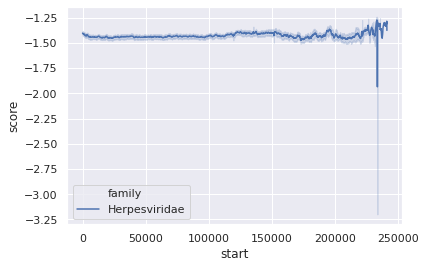

In [6]:
sns.lineplot(x="start", y="score", hue="family", data=all_df)

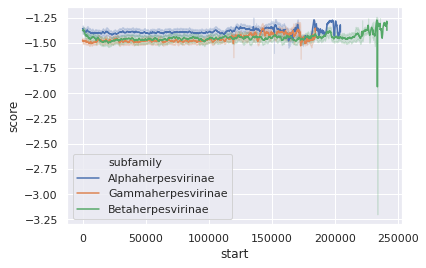

In [7]:
sns.lineplot(x="start", y="score", hue="subfamily", data=all_df)

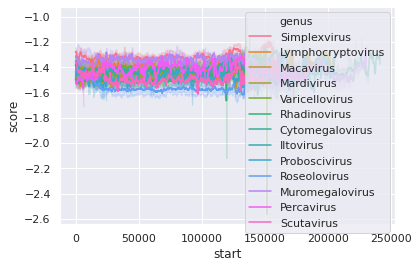

In [8]:
sns.lineplot(x="start", y="score", hue="genus", data=all_df)

## HMM rolling scores

In [9]:
fasta_id = "NC_014567.1"

model = util.hmms.load_hmm(fasta_id)

### to self

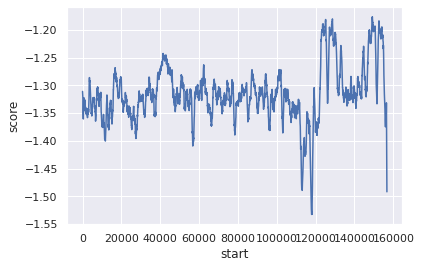

In [10]:
scores = util.hmms.rolling_score(records[fasta_id], model, metadata)

df = pd.DataFrame(scores)
sns.lineplot(x="start", y="score", data=df)

### to other in same subfamily

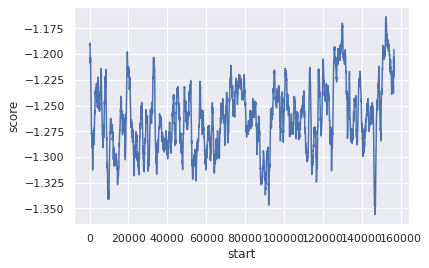

In [11]:
subfamily_fasta_id = "NC_007653.1"
scores = util.hmms.rolling_score(records[subfamily_fasta_id], model, metadata)

df = pd.DataFrame(scores)
sns.lineplot(x="start", y="score", data=df)

### to other in other subfamily

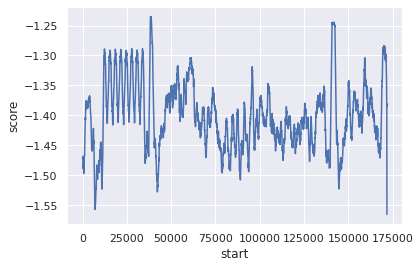

In [12]:
other_subfamily_fasta_id = "NC_007605.1"
scores = util.hmms.rolling_score(records[other_subfamily_fasta_id], model, metadata)

df = pd.DataFrame(scores)
sns.lineplot(x="start", y="score", data=df)

## Rolling GC content

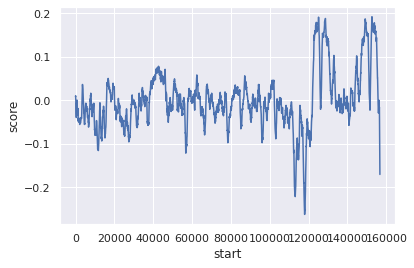

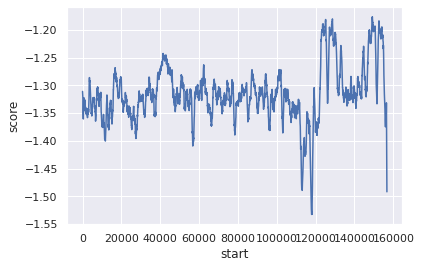

In [13]:
scores = util.gc.rolling_gc(records[fasta_id], metadata)

gc = pd.DataFrame(scores)
sns.lineplot(x="start", y="score", data=gc)

scores = util.hmms.rolling_score(records[fasta_id], model, metadata)
hmm_score = pd.DataFrame(scores)
plt.figure()
sns.lineplot(x="start", y="score", data=hmm_score)

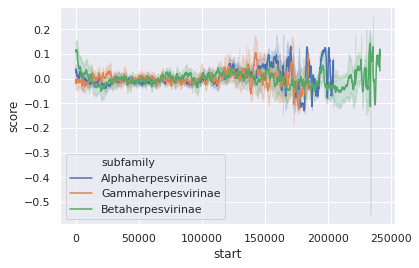

In [14]:
scores = []
for record in records.values():
    scores.extend(util.gc.rolling_gc(record, metadata))

all_gc = pd.DataFrame(scores)

sns.lineplot(x="start", y="score", hue="subfamily", data=all_gc)

## Rolling k-mer frequencies

/home/kalior/.local/share/virtualenvs/algorithms-in-bioninformatics-N37OUTIt/lib/python3.7/site-packages/Bio/Seq.py:175: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


[None]

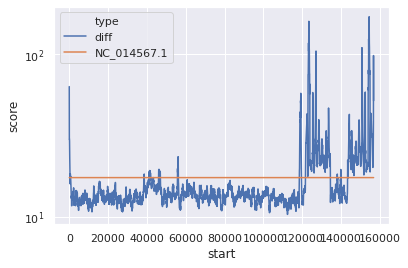

In [15]:
scores = util.kmers.rolling_k_mer_composition(records["NC_014567.1"], records["NC_014567.1"], 4, metadata)

tetramer = pd.DataFrame(scores)
ax = sns.lineplot(x="start", y="score", hue="type", data=tetramer)
ax.set(yscale="log")

/home/kalior/.local/share/virtualenvs/algorithms-in-bioninformatics-N37OUTIt/lib/python3.7/site-packages/Bio/Seq.py:175: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


[None]

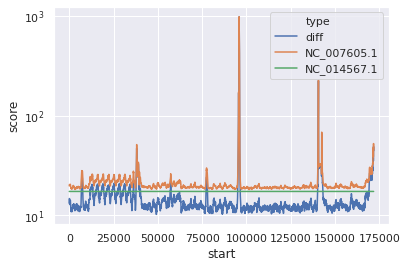

In [4]:
scores = util.kmers.rolling_k_mer_composition(records["NC_007605.1"], records["NC_014567.1"], 4, metadata)

tetramer = pd.DataFrame(scores)
ax = sns.lineplot(x="start", y="score", hue="type", data=tetramer)
ax.set(yscale="log")

/home/kalior/.local/share/virtualenvs/algorithms-in-bioninformatics-N37OUTIt/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


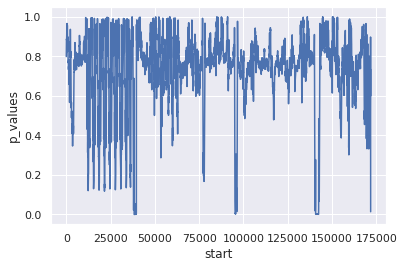

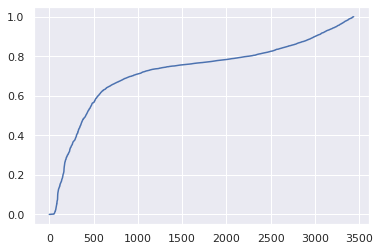

In [13]:
one = np.array([v for v in tetramer[tetramer.type == "NC_007605.1"]["kmers"].values])
two = np.array([v for v in tetramer[tetramer.type == "NC_014567.1"]["kmers"].values])

_, p_values = scipy.stats.ttest_ind(one, two, axis=1)

df = tetramer.loc[tetramer.type == "NC_007605.1", :]
df["p_values"] = p_values
ax = sns.lineplot(x="start", y="p_values", data=df)

plt.figure()
sns.lineplot(x=np.arange(len(p_values)), y=sorted(p_values))


[None]

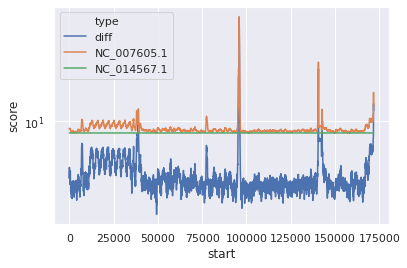

In [17]:
scores = util.kmers.rolling_k_mer_composition(records["NC_007605.1"], records["NC_014567.1"], 3, metadata)

trimer = pd.DataFrame(scores)
ax = sns.lineplot(x="start", y="score", hue="type", data=trimer)
ax.set(yscale="log")

[None]

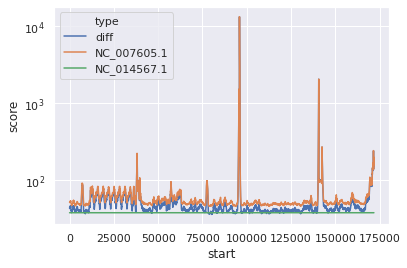

In [18]:
scores = util.kmers.rolling_k_mer_composition(records["NC_007605.1"], records["NC_014567.1"], 5, metadata)

pentamer = pd.DataFrame(scores)
ax = sns.lineplot(x="start", y="score", hue="type", data=pentamer)
ax.set(yscale="log")

## Graph of shared k-mers

In [16]:
graph = util.kmers.shared_kmer_network(records.values(), k=22)

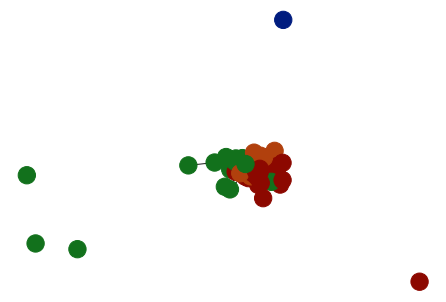

In [17]:
metas = list(set(metadata["subfamily"].values))
mappable_colors = sns.color_palette("dark", n_colors=len(metas))
colors = {meta: mappable_colors[metas.index(meta)] for meta in metas}
node_colors = [
    colors[metadata[metadata.aid == node]["subfamily"].values[0]]
    for node in graph.nodes
]
nx.draw(graph, node_color=node_colors)

In [18]:
single_nodes = [node for node, degree in graph.degree() if degree == 0]
print(single_nodes)
graph.remove_nodes_from(single_nodes)

['NC_038267.1', 'NC_038937.1', 'NC_043053.1', 'NC_043060.1', 'NC_043063.1']


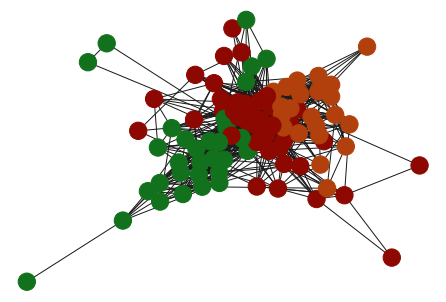

In [19]:
for subgraph in [graph.subgraph(c).copy() for c in nx.connected_components(graph)]:
    plt.figure()
    node_colors = [
        colors[metadata[metadata.aid == node]["subfamily"].values[0]]
        for node in subgraph.nodes
    ]
    nx.draw(subgraph, node_color=node_colors)

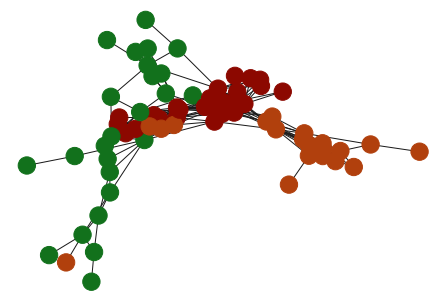

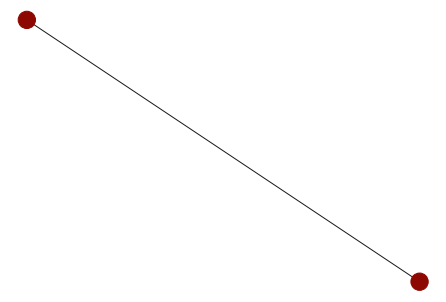

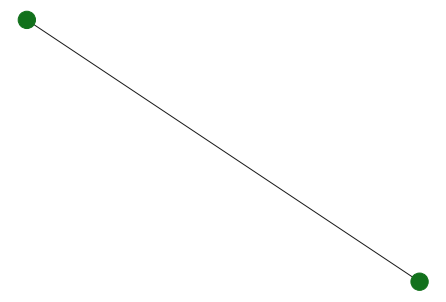

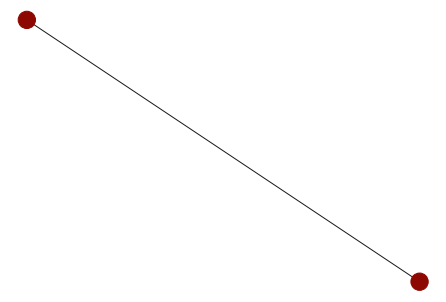

In [20]:
graph = util.kmers.shared_kmer_network(records.values(), k=31)

single_nodes = [node for node, degree in graph.degree() if degree == 0]
graph.remove_nodes_from(single_nodes)

for subgraph in [graph.subgraph(c).copy() for c in nx.connected_components(graph)]:
    plt.figure()
    node_colors = [
        colors[metadata[metadata.aid == node]["subfamily"].values[0]]
        for node in subgraph.nodes
    ]
    nx.draw(subgraph, node_color=node_colors)

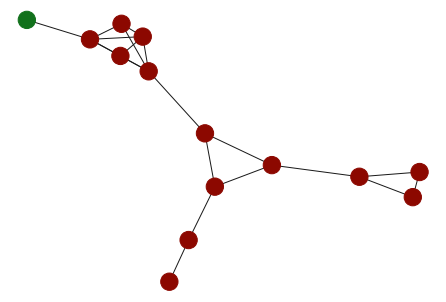

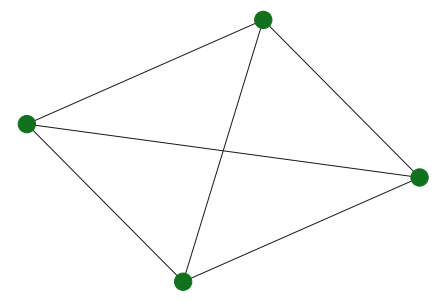

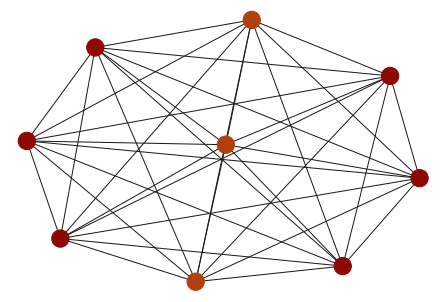

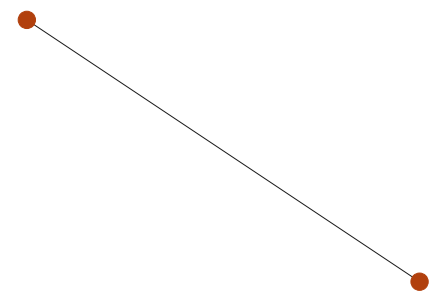

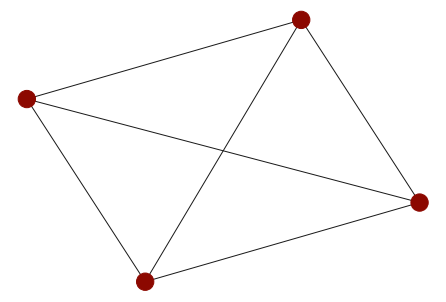

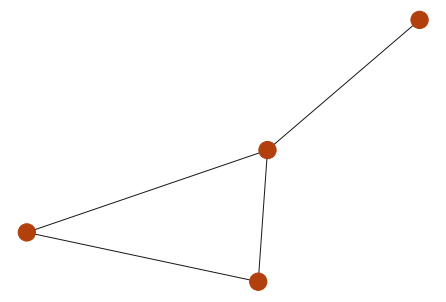

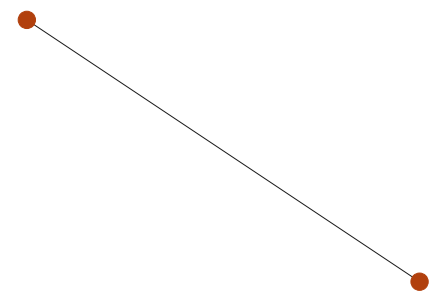

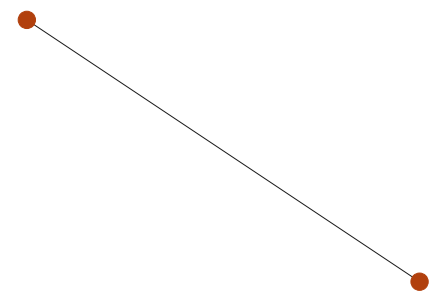

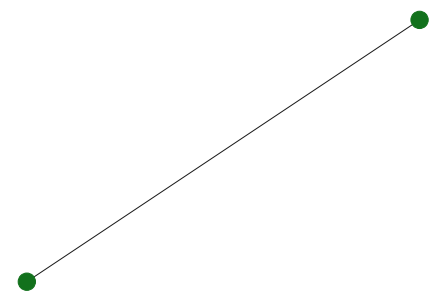

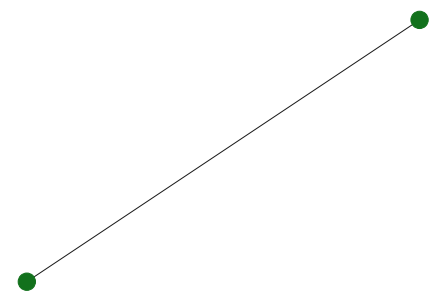

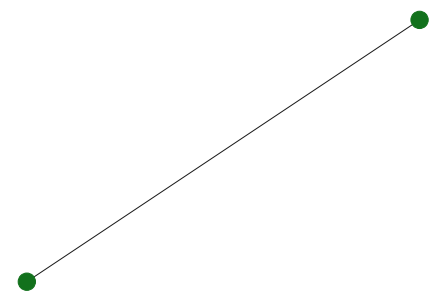

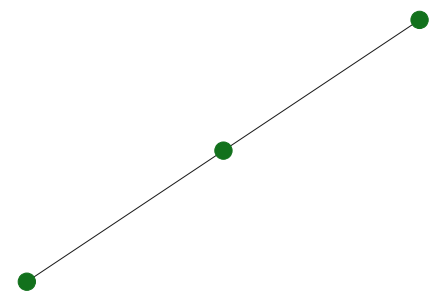

In [21]:
graph = util.kmers.shared_kmer_network(records.values(), k=60)

single_nodes = [node for node, degree in graph.degree() if degree == 0]
graph.remove_nodes_from(single_nodes)

for subgraph in [graph.subgraph(c).copy() for c in nx.connected_components(graph)]:
    plt.figure()
    node_colors = [
        colors[metadata[metadata.aid == node]["subfamily"].values[0]]
        for node in subgraph.nodes
    ]
    nx.draw(subgraph, node_color=node_colors)